In [1]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, grad
from jax import random
import optax
import numpy as np
import pickle

In [2]:
def init_network_params(sizes, key=random.PRNGKey(4)):
    def random_layer_params(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return scale * random.uniform(w_key, (n, m), minval=1, maxval=3), scale * random.uniform(b_key, (n,), minval=1, maxval=3)

    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def predict(NN, x):
    activations = x.reshape((-1, ))
    for w, b in NN[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = jax.nn.sigmoid(outputs)
    final_w, final_b = NN[-1]
    logit = jnp.dot(final_w, activations) + final_b
    logit = 1/(1+jnp.exp(-logit))
    return logit.squeeze()

vpredict = vmap(predict, in_axes=(None, 0))
gpredict = grad(predict, argnums=1)
vgpredict = vmap(gpredict, in_axes=(None, 0))

In [3]:
def pi(x):
    return (1 / jnp.sqrt(2 * jnp.pi)) * jnp.exp(-0.5 * x**2)
vpi = vmap(pi, in_axes=(0,))

def pi_pre(NN, x):
    result = gpredict(NN, x)
    return result

@jit
def obj(NN, x_batch):
    def obj1(NN, x):
        return pi(x) - pi_pre(NN, x)
    vobj1 = vmap(obj1, in_axes=(None, 0))

    result = vobj1(NN, x_batch)
    result = jnp.square(result)
    result = jnp.mean(result)
    return result
jgo = jit(grad(obj))

@jit
def evaluation(NN, test_zu):
    z_batch, u_batch = test_zu[:, 0], test_zu[:, 1]
    result = jnp.square(vpredict(NN, z_batch) - u_batch)
    result = jnp.mean(result)
    return result

In [ ]:
LAYER_SIZES = [1, 10, 10, 10, 1]
NN = init_network_params(LAYER_SIZES, random.PRNGKey(15))

optimizer= optax.adam(0.001)
opt_state = optimizer.init(NN)
test_zu = np.load('/content/drive/MyDrive/No. 22 Physica D (forward)/Normal checkpoints (PINN)/test_zu.npy')
lowest = evaluation(NN, test_zu)
Lloss = []
Llowest = []
for epoch in range(2000000):
    x_batch = np.random.uniform(-4, 4, (10000, 1)) #1000 refers to batch size

    grads = grad(obj)(NN, x_batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    NN = optax.apply_updates(NN, updates)

    Lloss.append(obj(NN, x_batch).item())
    Llowest.append(lowest.item())
    print(f"Epoch: {epoch}, loss:{obj(NN, x_batch)}, {lowest}")

    if  evaluation(NN, test_zu)<lowest:
        lowest = evaluation(NN, test_zu)
        NN_best = NN

    if epoch % 10000 == 0:
        np.save(f'/content/drive/MyDrive/No. 22 Physica D (forward)/Normal checkpoints (PINN)/Interval 4/Lloss.npy', Lloss)
        np.save(f'/content/drive/MyDrive/No. 22 Physica D (forward)/Normal checkpoints (PINN)/Interval 4/Llowest.npy', Llowest)
        with open(f'/content/drive/MyDrive/No. 22 Physica D (forward)/Normal checkpoints (PINN)/Interval 4/NN (best).pkl', 'wb') as f:
            pickle.dump(NN_best, f)
        with open(f'/content/drive/MyDrive/No. 22 Physica D (forward)/Normal checkpoints (PINN)/Interval 4/NN_{epoch}.pkl', 'wb') as f:
            pickle.dump(NN, f)

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch: 1782634, loss:8.414271057688438e-09, 2.4607109683216777e-09
Epoch: 1782635, loss:7.302439541945205e-09, 2.4607109683216777e-09
Epoch: 1782636, loss:6.084862835820104e-09, 2.4607109683216777e-09
Epoch: 1782637, loss:5.415663473229415e-09, 2.4607109683216777e-09
Epoch: 1782638, loss:5.08445729963114e-09, 2.4607109683216777e-09
Epoch: 1782639, loss:4.660213104301647e-09, 2.4607109683216777e-09
Epoch: 1782640, loss:4.3545331784855534e-09, 2.4607109683216777e-09
Epoch: 1782641, loss:4.4304919732951475e-09, 2.4607109683216777e-09
Epoch: 1782642, loss:4.708438527956105e-09, 2.4607109683216777e-09
Epoch: 1782643, loss:5.64542856906769e-09, 2.4607109683216777e-09
Epoch: 1782644, loss:6.520365136708506e-09, 2.4607109683216777e-09
Epoch: 1782645, loss:6.973914778996004e-09, 2.4607109683216777e-09
Epoch: 1782646, loss:8.13049094716689e-09, 2.4607109683216777e-09
Epoch: 1782647, loss:9.187551164302477e-09, 2.4607109683216777e-09
Epoch: 1782648, loss:1.1453927584170

# Plot

In [ ]:
!pip install SciencePlots==1.0.9
!pip install SciencePlots==2.0.1
import scienceplots
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use(['grid', 'nature', 'vibrant', 'no-latex'])

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for SciencePlots: filename=SciencePlots-1.0.9-py3-none-any.whl size=6472 sha256=00620626a96f8d9a748a03d49d87c4bafe0a6b0b867325b4e7b5583718a41caa
  Stored in directory: /root/.cache/pip/wheels/b3/71/6a/18892a555ccbe175cf1bef9c8e777113092af56277be57eb5d
Successfully built SciencePlots
  Attempting uninstall: SciencePlots
    Found existing installation: SciencePlots 1.0.9
    Uninstalling SciencePlots-1.0.9:
      Successfully uninstalled SciencePlots-1.0.9


In [ ]:
L_LOSS = np.load('/content/drive/MyDrive/No. 22 Physica D/LLOSS_Normal_PINN.npy')
with open('/content/drive/MyDrive/No. 22 Physica D/NN_Normal_PINN.pkl', 'rb') as f:
    NN = pickle.load(f)

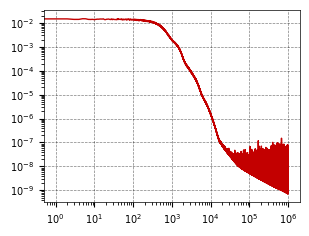

In [ ]:
index = np.arange(0, 1000000, 1)
plt.plot(index, L_LOSS[index], color='#c30000')
plt.yscale('log')
plt.xscale('log')

plt.savefig('A.pdf')

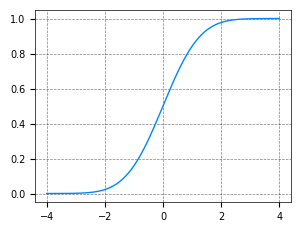

In [ ]:
index = np.arange(-4, 4, 0.0001)
vpredict = vmap(predict, in_axes=(None, 0))
result = vpredict(NN, index)

plt.plot(index, result, color='#0085ff')

plt.savefig('B.pdf')

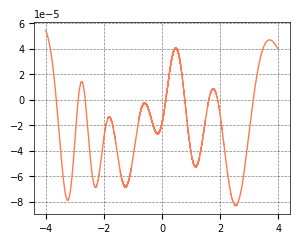

In [ ]:
index = np.arange(-4, 4, 0.0001)
vgpredict = vmap(gpredict, in_axes=(None, 0))
vpi = vmap(pi, in_axes=(0,))
result1 = vgpredict(NN, index)
result2 = vpi(index)

plt.plot(index, result1-result2, color='#ff7a50')

plt.savefig('C.pdf')